# 1. Library Imports

In [49]:
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 2. Load Pre-Processed Data

In [14]:
adata = sc.read("../data/processed/pbmc3k_preprocessed.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 2638 × 2013
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


# 3. Visualizations and Annotations

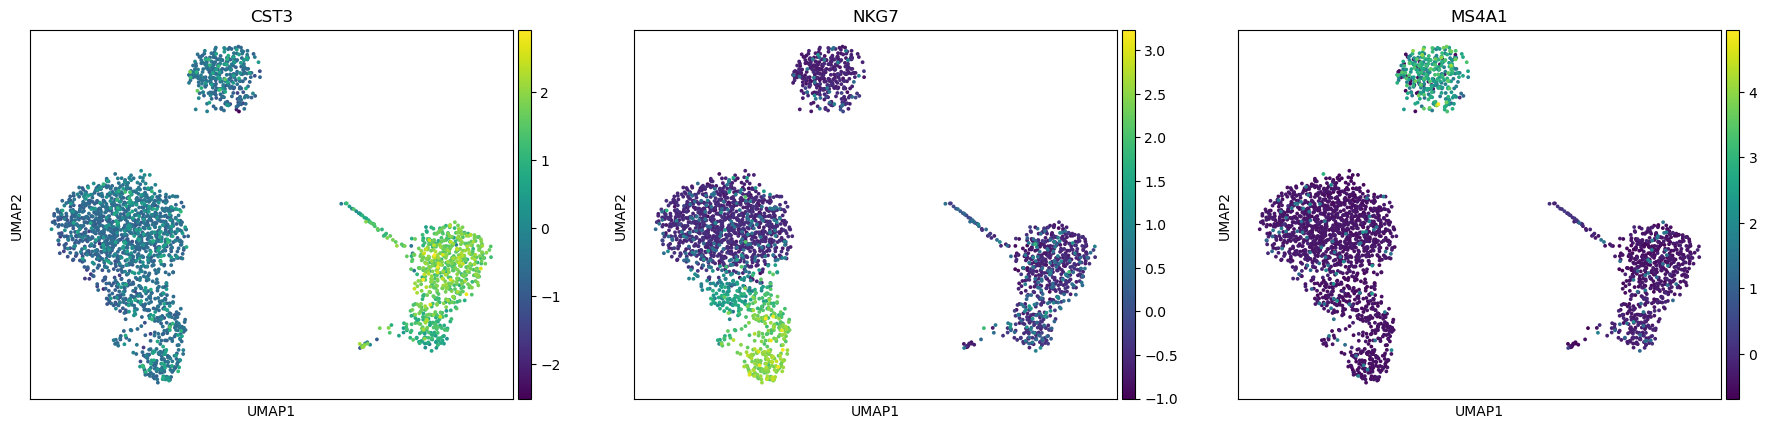

In [20]:
marker_genes = ['CST3', 'NKG7', 'MS4A1']
sc.pl.umap(adata, color=marker_genes, cmap='viridis', size=30)

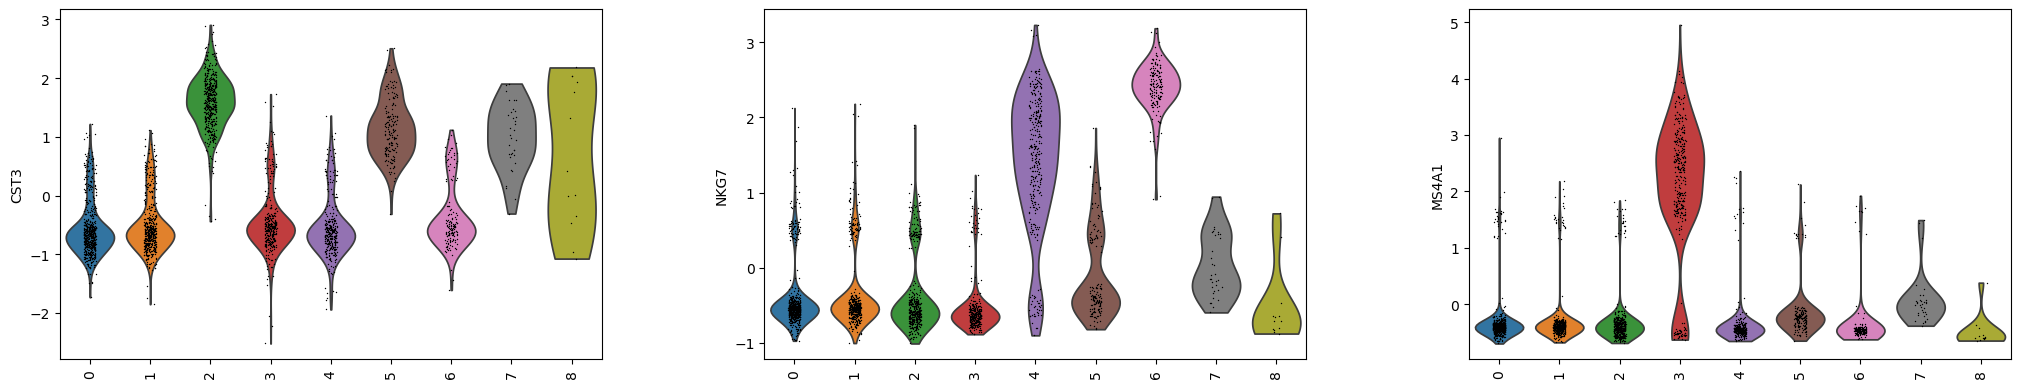

In [ ]:
sc.pl.violin(adata, marker_genes, groupby='leiden', rotation=90)

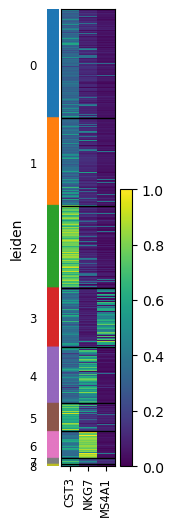

In [22]:
sc.pl.heatmap(adata, var_names=marker_genes, groupby='leiden', standard_scale='var')

In [23]:
cluster_to_celltype = {
    '2': 'Monocytes',  # CST3-high
    '3': 'B cells',    # MS4A1-high
    '6': 'NK cells',   # NKG7-high
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

In [24]:
# List of Marker Genes
marker_genes = ['MS4A1','CD19','CD79A','CD3D','CD3E','CD4','CD8A','CD8B','NKG7','NCAM1','GNLY','CST3','CD14','LYZ','FCER1A','CLEC9A','PPBP']

present_markers = [gene for gene in marker_genes if gene in adata.var_names]
print("Markers present in dataset:", present_markers)

Markers present in dataset: ['MS4A1', 'CD19', 'CD79A', 'NKG7', 'GNLY', 'CST3', 'FCER1A', 'PPBP']


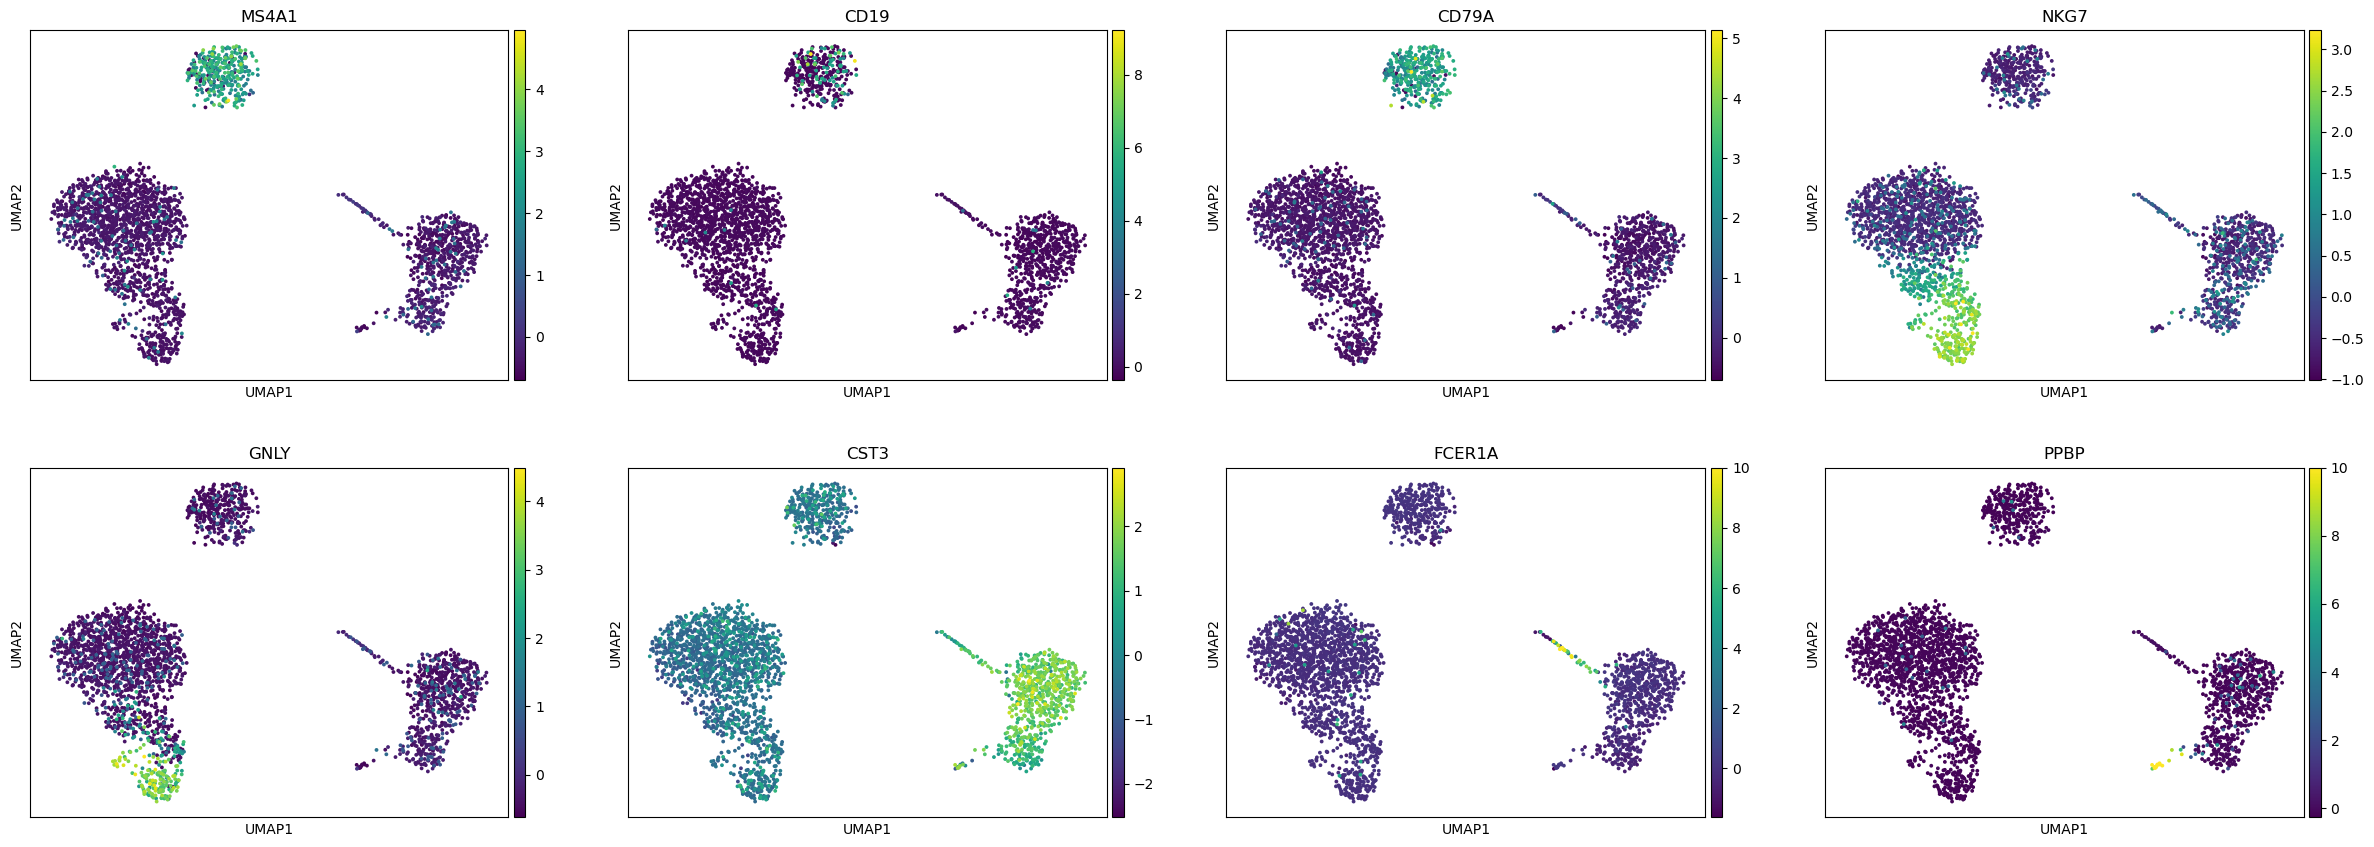

In [25]:
sc.pl.umap(adata, color=present_markers, cmap='viridis', size=30)

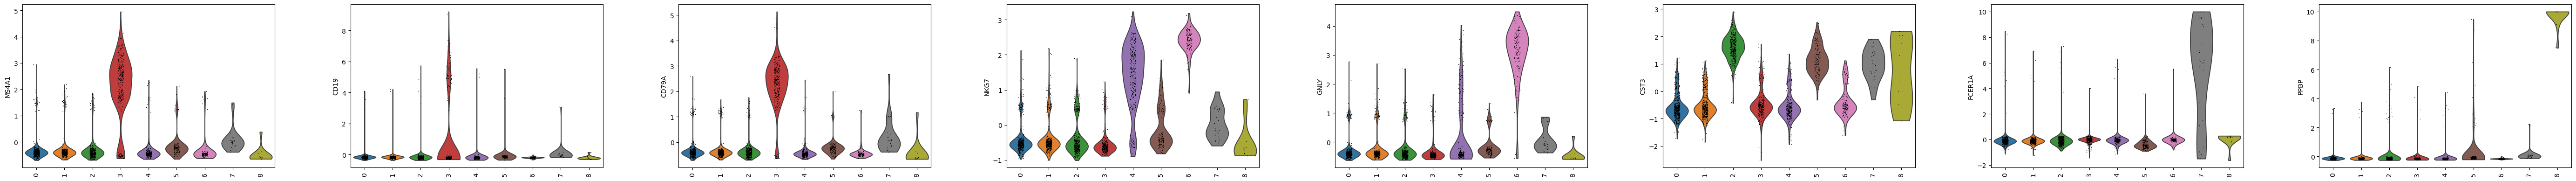

In [26]:
sc.pl.violin(adata, present_markers, groupby='leiden', rotation=90)

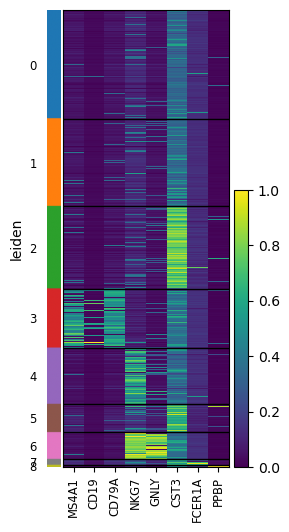

In [27]:
sc.pl.heatmap(adata, var_names=present_markers, groupby='leiden', standard_scale='var')

After performing unsupervised clustering with Leiden Clustering during preprocessing, I annotated the resulting clusters using a **marker gene dictionary** derived from canonical immunology knowledge. Each cluster’s average expression was compared against a curated set of cell type–specific markers, e.g. MS4A1 for B cells, CD3D/CD4 for CD4 T cells, CD3D/CD8A for CD8 T cells, NKG7 for NK cells, CST3/CD14 for monocytes.

In [37]:
# Dictionary of canonical PBMC markers
marker_dict = {
    'B cells': ['MS4A1', 'CD19', 'CD79A'],
    'CD4 T cells': ['CD3D', 'CD3E', 'CD4'],
    'CD8 T cells': ['CD3D', 'CD8A', 'CD8B'],
    'NK cells': ['NKG7', 'NCAM1', 'GNLY'],
    'Monocytes': ['CST3', 'CD14', 'LYZ'],
    'Dendritic cells': ['FCER1A', 'CLEC9A'],
    'Platelets': ['PPBP']
}

for cell_type in marker_dict:
    marker_dict[cell_type] = [gene for gene in marker_dict[cell_type] if gene in adata.var_names]

marker_dict

{'B cells': ['MS4A1', 'CD19', 'CD79A'],
 'CD4 T cells': [],
 'CD8 T cells': [],
 'NK cells': ['NKG7', 'GNLY'],
 'Monocytes': ['CST3'],
 'Dendritic cells': ['FCER1A'],
 'Platelets': ['PPBP']}

In [40]:
def assign_cell_types(adata, cluster_key='leiden', marker_dict=marker_dict):
    cluster_ids = adata.obs[cluster_key].unique()
    cluster_to_celltype = {}
    
    for cluster in cluster_ids:
        cluster_cells = adata[adata.obs[cluster_key] == cluster]
        
        mean_expr = {}
        for cell_type, markers in marker_dict.items():
            if len(markers) == 0:
                continue
            mean_expr[cell_type] = cluster_cells[:, markers].X.mean()
        
        if mean_expr:
            assigned_type = max(mean_expr, key=mean_expr.get)
            cluster_to_celltype[cluster] = assigned_type
        else:
            cluster_to_celltype[cluster] = 'Unknown'
    
    adata.obs['cell_type'] = adata.obs[cluster_key].map(cluster_to_celltype)
    
    return cluster_to_celltype

In [41]:
cluster_mapping = assign_cell_types(adata)
print(cluster_mapping)

{'0': 'Dendritic cells', '3': 'B cells', '1': 'Dendritic cells', '5': 'Monocytes', '6': 'NK cells', '4': 'NK cells', '2': 'Monocytes', '7': 'Dendritic cells', '8': 'Platelets'}


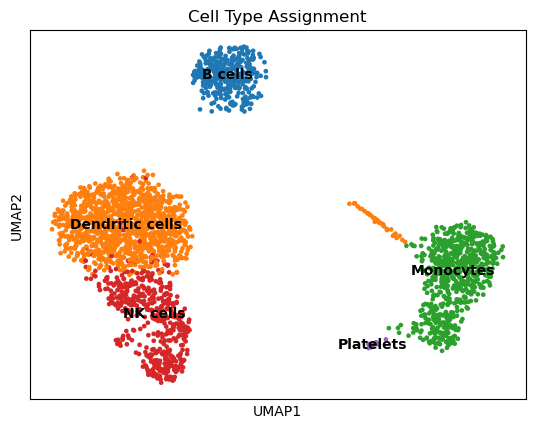

In [43]:
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='Cell Type Assignment')

# 4. Classification

In [50]:
X = adata[:, adata.var["highly_variable"]].X.toarray()
y = adata.obs["cell_type"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [54]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(pd.Categorical(y_train).codes, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(pd.Categorical(y_test).codes, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)